### - Sobhan Moradian Daghigh
#### - 5/20/2022
#### - ANN - HW05

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import urllib
import tensorflow as tf, keras
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.merge import concatenate

import warnings
warnings.filterwarnings("ignore")

import itertools

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [138]:
print(tf.__version__)

2.8.0


In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/logs', histogram_freq=1)

In [141]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = 0
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    current_acc = logs.get('accuracy')
    if np.less(self.best, current_acc):
      self.best = current_acc
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if np.greater_equal(self.wait, self.patience):
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

In [142]:
es_callback = EarlyStoppingCallback(patience=3)

# Load Data

In [143]:
def load_data(base_url, names):
  datas = []
  labels = []
  for name in names:
    file = urllib.request.urlopen(base_url + '{}.data'.format(name))
    while True:
      # Reading label
      label = file.readline().decode("utf-8").strip()

      # EOF
      if label is '':
        break

      label = 1 if label in ['normal', 'ok'] else 0
      labels.append(label)

      # Packing each 15 datas
      pack = []
      for _ in range(15):
        data = [np.float64(x) for x in (file.readline().decode("utf-8")[:-1].split('\t')[1:])]
        pack.append(data)
      datas.append(pack)

      # Skipping for two empty lines
      file.readline()
      file.readline()

  return np.array(datas), np.array(labels)

In [144]:
base_url = 'https://raw.githubusercontent.com/nahbos/AUT-Neural-Networks/main/HW05/data/'
names = ['lp1', 'lp2', 'lp3', 'lp4', 'lp5']
datas, labels = load_data(base_url, names)

In [145]:
datas.shape

(463, 15, 6)

In [146]:
x_temp, x_test, y_temp, y_test = train_test_split(datas, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=42)

In [147]:
x_train.shape

(323, 15, 6)

In [148]:
x_val.shape

(47, 15, 6)

In [149]:
x_test.shape

(93, 15, 6)

# Elman Neural Network
#### Implementation is based on Elman algorithm and rules
##### Some useful links:
##### [Elman](https://www.youtube.com/watch?v=e2sGq_vI41s&list=PLC112AD1C69432FDB&index=4)
##### [Deep Learning with Python book - page 197](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf)

In [150]:
class Elman(tf.keras.Model):
  def __init__(self, input_dim, hidden_units, feature_size, n_classes):
    super().__init__()
    self.hidden_units = hidden_units
    self.feature_size = feature_size
    self.input_dim = input_dim
    self.n_classes = n_classes

    # The names are based on the pseudo code in the book which linked above.

    self.W = self.add_weight(shape=(self.hidden_units, self.feature_size), initializer='random_normal', trainable=True)
    self.U = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

    self.W_y = self.add_weight(shape=(self.n_classes, self.hidden_units), initializer='random_normal', trainable=True)
    self.b_y = self.add_weight(shape=(self.n_classes,), initializer='random_normal', trainable=True)

  def call(self, x):
    state_t = tf.zeros(self.hidden_units)
    for i in range(self.input_dim):
      state_t = tf.keras.activations.tanh(tf.matmul(self.W, tf.cast(tf.reshape(x[0][i], (self.feature_size, 1)), tf.float32)) + tf.matmul(self.U, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b, (self.hidden_units, 1)))

    y = tf.keras.activations.tanh(tf.matmul(self.W_y, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b_y, (self.n_classes,1)))
    return y

In [151]:
def evaluate(model, x_datas, y_datas):
  predictions = []
  for data in x_datas:
    res = model.call(tf.convert_to_tensor(np.array([data])))
    res = 1 if np.array(res)[0] > 0.5 else 0
    predictions.append(res)

  return accuracy_score(y_datas, predictions)

In [152]:
elman = Elman(input_dim=15, hidden_units=45, feature_size=6, n_classes=2)

In [153]:
elman.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [154]:
elman.fit(x_train, y_train, batch_size=1, epochs=20, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/20
323/323 [==============================] - 61s 4ms/step - loss: 1.1412 - accuracy: 0.7384 - val_loss: 0.4050 - val_accuracy: 0.7340
Epoch 2/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3477 - accuracy: 0.7988 - val_loss: 0.3607 - val_accuracy: 0.8298
Epoch 3/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3268 - accuracy: 0.8127 - val_loss: 0.3458 - val_accuracy: 0.8191
Epoch 4/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3025 - accuracy: 0.8560 - val_loss: 0.3490 - val_accuracy: 0.7979
Epoch 5/20
323/323 [==============================] - 1s 3ms/step - loss: 0.2901 - accuracy: 0.8483 - val_loss: 0.3965 - val_accuracy: 0.7340
Epoch 6/20
323/323 [==============================] - 1s 3ms/step - loss: 0.2918 - accuracy: 0.8375 - val_loss: 0.3154 - val_accuracy: 0.7979
Epoch 7/20
323/323 [==============================] - 1s 3ms/step - loss: 0.2632 - accuracy: 0.8607 - val_loss: 0.2714 - val_accuracy: 0.8298
Epoch

In [155]:
evaluate(model=elman, x_datas=x_test, y_datas=y_test)

0.8602150537634409

In [175]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

In [158]:
stop

NameError: ignored

## Jordan

In [159]:
class Jordan(tf.keras.Model):
    def __init__(self, input_dim, hidden_units, feature_size, n_classes):
        super().__init__()
        self.hidden_units = hidden_units
        self.feature_size = feature_size
        self.input_dim = input_dim
        self.n_classes = n_classes

        # The names are based on the pseudo code in the book which linked above.

        self.W = self.add_weight(shape=(self.hidden_units, self.feature_size), initializer='random_normal', trainable=True)
        self.U = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y_intermediate = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y_intermediate = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y = self.add_weight(shape=(self.n_classes, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y = self.add_weight(shape=(self.n_classes,), initializer='random_normal', trainable=True)

    def call(self, x):
        state_t = tf.zeros(self.hidden_units)
        for i in range(self.input_dim):
            hidden = tf.keras.activations.tanh(tf.matmul(self.W, tf.cast(tf.reshape(x[0][i], (self.feature_size, 1)), tf.float32)) + tf.matmul(self.U, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b, (self.hidden_units, 1)))
            state_t = tf.keras.activations.tanh(tf.matmul(self.W_y_intermediate, tf.reshape(hidden, (self.hidden_units,1))) + tf.reshape(self.b_y_intermediate, (self.hidden_units,1)))
        y = tf.keras.activations.tanh(tf.matmul(self.W_y, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b_y, (self.n_classes,1)))

        return y

In [160]:
jordan = Jordan(input_dim=15, hidden_units=25, feature_size=6, n_classes=2)

In [161]:
jordan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [162]:
jordan.fit( x_train, y_train, batch_size=1, epochs=20, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/20
323/323 [==============================] - 4s 5ms/step - loss: 0.5244 - accuracy: 0.6935 - val_loss: 0.3789 - val_accuracy: 0.7872
Epoch 2/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.7972 - val_loss: 0.3566 - val_accuracy: 0.7872
Epoch 3/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3394 - accuracy: 0.8235 - val_loss: 0.3462 - val_accuracy: 0.8085
Epoch 4/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8375 - val_loss: 0.3782 - val_accuracy: 0.7128
Epoch 5/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3078 - accuracy: 0.8266 - val_loss: 0.3371 - val_accuracy: 0.7872
Epoch 6/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3057 - accuracy: 0.8142 - val_loss: 0.2960 - val_accuracy: 0.8830
Epoch 7/20
323/323 [==============================] - 1s 3ms/step - loss: 0.2760 - accuracy: 0.8498 - val_loss: 0.3108 - val_accuracy: 0.8511
Epoch 

In [163]:
evaluate(model=jordan, x_datas=x_test, y_datas=y_test)

0.8279569892473119

In [174]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

In [166]:
stop

NameError: ignored

## Ensemble

In [167]:
def stacked_ensemble(models):
  for i in range(len(models)):
  	model = models[i]
  	for layer in model.layers:
  		# layer.trainable = False
  		layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

  ensemble_visible = [model.input for model in elman_models]
  ensemble_outputs = [model.output for model in elman_models]
  merge = concatenate(ensemble_outputs)
  output = Dense(1, activation='sigmoid')(merge)
  output = Flatten()(output)
  
  model = Model(inputs=ensemble_visible, outputs=output)

  plot_model(model, show_shapes=True, to_file='model_graph.png')

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [168]:
elman_models = []
neurons = [15, 25, 35, 45, 55]
for neuron in neurons:
  elman1 = Elman(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=2)
  elman1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, elman1(input))
  elman_models.append(model)

In [169]:
ensemble_elman = stacked_ensemble(elman_models)

In [170]:
ensemble_elman.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

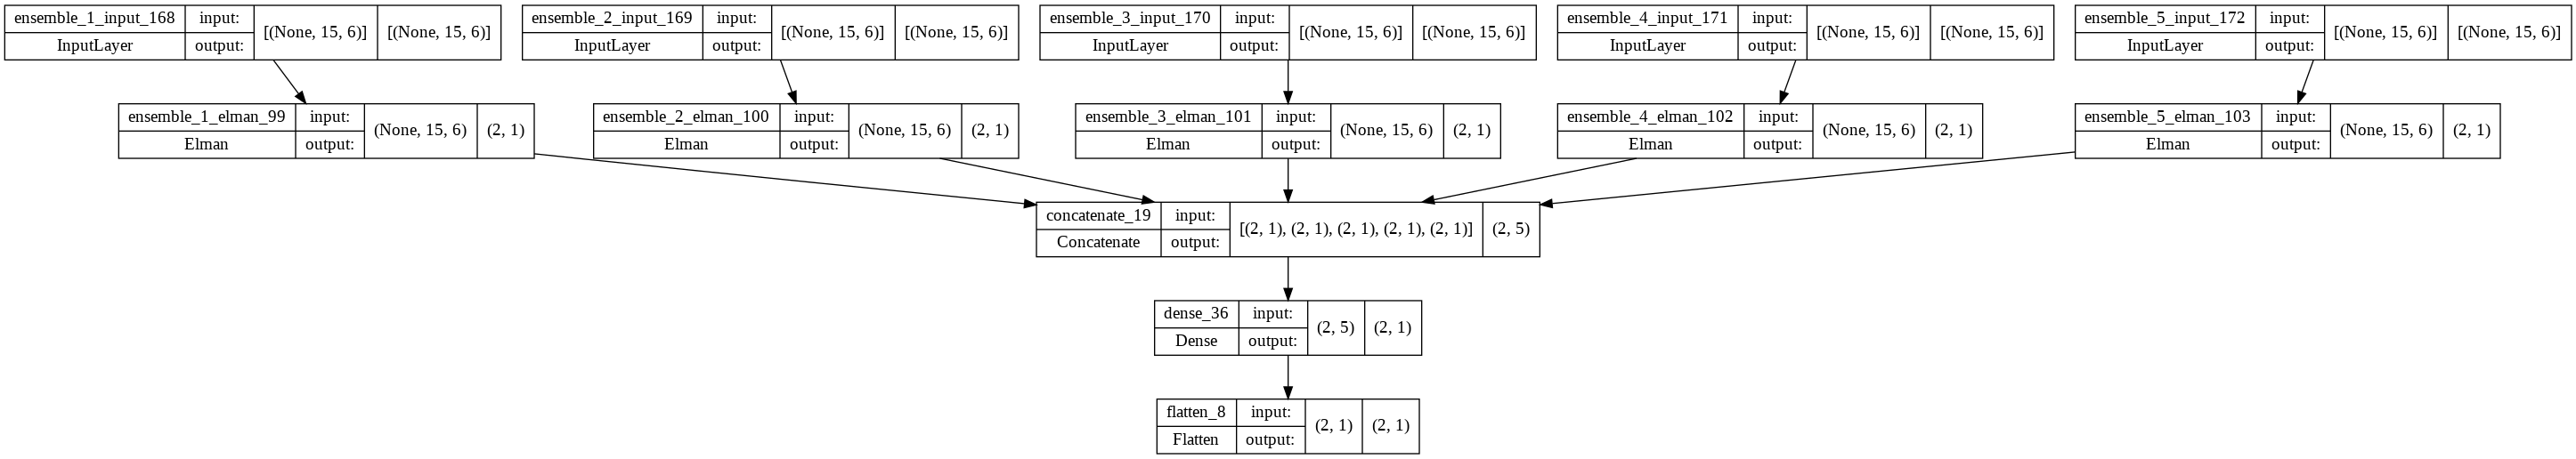

In [171]:
plot_model(ensemble_elman, show_shapes=True, show_layer_names=True, expand_nested=True)

In [172]:
X = [x_train for _ in range(len(ensemble_elman.input))]
val = [x_val for _ in range(len(ensemble_elman.input))]
ensemble_elman.fit(X, y_train, batch_size=1, epochs=20, validation_data=(val, y_val), callbacks=[tb_callback])

Epoch 1/20
323/323 [==============================] - 9s 11ms/step - loss: 0.5815 - accuracy: 0.6842 - val_loss: 0.5070 - val_accuracy: 0.7660
Epoch 2/20
323/323 [==============================] - 2s 5ms/step - loss: 0.4464 - accuracy: 0.7755 - val_loss: 0.4319 - val_accuracy: 0.7979
Epoch 3/20
323/323 [==============================] - 2s 5ms/step - loss: 0.3757 - accuracy: 0.8111 - val_loss: 0.3569 - val_accuracy: 0.8723
Epoch 4/20
323/323 [==============================] - 2s 5ms/step - loss: 0.3556 - accuracy: 0.8096 - val_loss: 0.4520 - val_accuracy: 0.7128
Epoch 5/20
323/323 [==============================] - 2s 6ms/step - loss: 0.3084 - accuracy: 0.8514 - val_loss: 0.3522 - val_accuracy: 0.8191
Epoch 6/20
323/323 [==============================] - 2s 6ms/step - loss: 0.2905 - accuracy: 0.8700 - val_loss: 0.3242 - val_accuracy: 0.8723
Epoch 7/20
323/323 [==============================] - 2s 5ms/step - loss: 0.2812 - accuracy: 0.8653 - val_loss: 0.2859 - val_accuracy: 0.8723
Epoch

In [173]:
test = [[x_test[0]] for _ in range(len(ensemble_elman.input))]
print(np.array(test).shape)
ensemble_elman.predict(test)

(5, 1, 15, 6)


ValueError: ignored

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/logs'